## Try any kind of simple fit and put it then into the pymc stuff

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=20)
import warnings
warnings.filterwarnings("once", category=DeprecationWarning)  # noqa: E402
import scipy
# imports from OGGM
import oggm
from oggm import utils, workflow, tasks, cfg, entity_task
import numpy as np
import pandas as pd
from MBsandbox.mbmod_daily_oneflowline import (TIModel_Sfc_Type, TIModel, process_w5e5_data)
from MBsandbox.wip.projections_bayescalibration import process_isimip_data, process_isimip_data_no_corr
from MBsandbox.help_func import (minimize_winter_mb_brentq_geod_via_pf,
                                 minimize_bias_geodetic,
                                 calibrate_to_geodetic_bias_winter_mb)
from MBsandbox.mbmod_daily_oneflowline import compile_fixed_geometry_mass_balance_TIModel
import time
import logging

log = logging.getLogger(__name__)

climate_type = 'W5E5'

# get the geodetic calibration data
pd_geodetic_all = utils.get_geodetic_mb_dataframe()
# pd_geodetic_all = pd.read_hdf(path_geodetic, index_col='rgiid')
pd_geodetic = pd_geodetic_all.loc[pd_geodetic_all.period == '2000-01-01_2020-01-01']


#pd_wgms_ref_glac_analysis = pd.read_csv('/home/lilianschuster/Schreibtisch/PhD/wgms_data_analysis/wgms_data_analysis.csv', index_col=[0])
#rgis_w_mb_profiles = pd_wgms_ref_glac_analysis[pd_wgms_ref_glac_analysis.MB_profile.dropna()].index

import MBsandbox
fp = utils.file_downloader('https://cluster.klima.uni-bremen.de/~lschuster/ref_glaciers' +
                           '/data/mb_overview_seasonal_mb_time_periods_20220301.csv')
pd_mb_overview = pd.read_csv(fp, index_col='Unnamed: 0')
fp_stats = utils.file_downloader('https://cluster.klima.uni-bremen.de/~lschuster/ref_glaciers' +
                           '/data/wgms_data_stats_20220301.csv')
pd_wgms_data_stats = pd.read_csv(fp_stats, index_col='Unnamed: 0')
# should have at least 5 annual MB estimates in the time period 1980-2019
# (otherwise can also not have MB profiles or winter MB!)
pd_wgms_data_stats = pd_wgms_data_stats.loc[pd_wgms_data_stats.len_annual_balance>=5]
ref_candidates = pd_wgms_data_stats.rgi_id.unique()

# for tests
#testing = testing
#if testing:
#    ref_candidates = ['RGI60-11.01450'] #rgis_w_mb_profiles #oggm.utils.get_ref_mb_glaciers_candidates()
#    working_dir = utils.gettempdir(dirname='OGGM_seasonal_mb_calib', reset=True)
#else:
working_dir = '/home/lilianschuster/Schreibtisch/PhD/bayes_2022/oct_2022_emulator/'
#utils.gettempdir(dirname='OGGM_seasonal_mb_calib', reset=False)

cfg.initialize()
cfg.PARAMS['use_multiprocessing'] = True #True
cfg.PATHS['working_dir'] = working_dir
cfg.PARAMS['hydro_month_nh'] = 1
cfg.PARAMS['hydro_month_sh'] = 1
cfg.PARAMS['continue_on_error'] = False
warnings.filterwarnings("ignore", category=DeprecationWarning) 

correction = False

/home/lilianschuster/micromamba/envs/oggm_pymc/lib/python3.9/site-packages/aeppl/rewriting.py:13: DeprecationWarning: `ShapeFeature` is now located in `aesara.tensor.rewriting.shape`.
  from aesara.tensor.rewriting.basic import (
/home/lilianschuster/micromamba/envs/oggm_pymc/lib/python3.9/site-packages/aeppl/utils.py:21: DeprecationWarning: `ShapeFeature` is now located in `aesara.tensor.rewriting.shape`.
  from aesara.tensor.rewriting.basic import ShapeFeature, topo_constant_folding
/home/lilianschuster/micromamba/envs/oggm_pymc/lib/python3.9/site-packages/aeppl/printing.py:29: DeprecationWarning: `ShapeFeature` is now located in `aesara.tensor.rewriting.shape`.
  from aesara.tensor.rewriting.basic import ShapeFeature
2022-10-24 12:17:50: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2022-10-24 12:17:50: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2022-10-24 12:17:50: oggm.cfg: Multiprocessing: using all available proc

In [2]:
from oggm.core import massbalance, climate


In [3]:
rgi_id = 'RGI60-11.01450'


In [4]:
cfg.PARAMS['border'] = 10
base_url = 'https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/L3-L5_files/elev_bands/w5e5/qc0/pcpwin/match_geod_pergla'

load = False
if load:    
    gdirs = workflow.init_glacier_directories(['RGI60-11.01450'], 
                                              from_prepro_level=3, prepro_base_url=base_url)

    t=workflow.execute_entity_task(tasks.compute_downstream_line, gdirs)
    t=workflow.execute_entity_task(tasks.compute_downstream_bedshape, gdirs)
    #if baseline_climate == 'W5E5':
    #if mb_type != 'mb_monthly':

    #t = workflow.execute_entity_task(process_w5e5_data, gdirs, climate_type=baseline_climate,
    #                              temporal_resol='monthly')
    #else:
    #t = workflow.execute_entity_task(process_w5e5_data, gdirs, climate_type=baseline_climate,
    #                          temporal_resol='daily')
    #t = workflow.execute_entity_task(process_era5_daily_data, gdirs, #climate_type=baseline_climate,
                              #temporal_resol='daily'process_era5_daily_data(gd)
    #                                )
else:
    rgi_id = 'RGI60-11.01450'
    gdirs = workflow.init_glacier_directories(['RGI60-11.01450'])

2022-10-24 12:17:55: oggm.cfg: PARAMS['border'] changed from `40` to `10`.
2022-10-24 12:17:55: oggm.workflow: Execute entity tasks [GlacierDirectory] on 1 glaciers


In [5]:
#import pymc as pm
import numpy as np
import arviz as az
import pandas as pd
import MBsandbox
from MBsandbox.wip import bayes_calib_geod_direct
from oggm import cfg, utils, workflow, tasks, graphics


In [6]:
load = False
if load:
    pd_spec_mb_gcm_vs_w5e5 = pd.DataFrame(np.NaN, index=np.arange(0, 1000000), #*len(gdirs))),
                                columns=['rgi_id', 'gcm', 'ssp',
                                        'spec_mb_2000_2019_gcm', 'spec_mb_2000_2019_w5e5',
                                         'spec_mb_2000_2019_obs', 'apply_bias_correction'])


    hgts, widths = gdir.get_inversion_flowline_hw()
    mb_mod = massbalance.PastMassBalance(gdir)
    spec_mb_2000_2019_w5e5 = mb_mod.get_specific_mb(heights=hgts, widths=widths,
                                                    year=np.arange(2000, 2019 + 1, 1)).mean()
    spec_mb_2000_2019_obs = pd_geod.loc[gdir.rgi_id].dmdtda*1000

In [7]:
import datetime
start_time = datetime.datetime.now()

columns = ['prcp_fac', 'melt_f', 'temp_bias', 'spec_mb_mean']
#columns = [*columns, *np.arange(2000, 2020,1).astype(str)]
#melt_f = 200
#spec_mbs = {}
load = False
if load:
    j = 0
    gdir = gdirs[0]

    pf_winter = oggm.core.climate.decide_winter_precip_factor(gdir)

    hgts, widths = gdir.get_inversion_flowline_hw()
    mb_mod = massbalance.PastMassBalance(gdir)
    
    pd_spec_mb = pd.DataFrame(columns = columns)
    for temp_bias in np.arange(-10, 10, 0.1):
        for prcp_fac in [pf_winter]:
            for melt_f in np.arange(10,1000, 10):
                mb_mod.prcp_fac = prcp_fac
                mb_mod.mu_star = melt_f
                mb_mod.temp_bias = temp_bias

                # just check if calibration worked ...
                spec_mb = mb_mod.get_specific_mb(heights=hgts, widths=widths,
                                                 year=np.arange(2000, 2020, 1))
                spec_mb_mean = spec_mb.mean()

                #spec_mbs[prcp_fac] = spec_mb
                pd_spec_mb.loc[j] = np.array([prcp_fac, melt_f, temp_bias, spec_mb_mean]) # , spec_mb))

                j+=1

    end_time = datetime.datetime.now()
    pd_spec_mb.to_csv(f'test_mb_{gdir.rgi_id}_fixed_pf.csv')
    #pd_spec_mb_sfc.to_csv('test_mb_sfc.csv')
else:
    pd_spec_mb = pd.read_csv(f'test_mb_{rgi_id}_fixed_pf.csv', index_col=[0])


In [72]:
utils.get_geodetic_mb_dataframe().loc[gdir.rgi_id]

,period,area,dmdtda,err_dmdtda,reg,is_cor
rgiid,,,,,,
RGI60-11.01450,2000-01-01_2010-01-01,82206000.0,-1.1896,0.1938,11,False
RGI60-11.01450,2000-01-01_2020-01-01,82206000.0,-1.2107,0.1315,11,False
RGI60-11.01450,2010-01-01_2020-01-01,82206000.0,-1.2317,0.1715,11,False


In [12]:
import datetime
start_time = datetime.datetime.now()

columns = ['prcp_fac', 'melt_f', 'temp_bias', 'spec_mb_mean']
#columns = [*columns, *np.arange(2000, 2020,1).astype(str)]
#melt_f = 200
#spec_mbs = {}
load = False
gdir = gdirs[0]

pf_winter = oggm.core.climate.decide_winter_precip_factor(gdir)

hgts, widths = gdir.get_inversion_flowline_hw()
mb_mod = massbalance.PastMassBalance(gdir)
if load:
    j = 0

    
    pd_spec_mb_test = pd.DataFrame(columns = columns)
    for temp_bias in np.arange(-10.05, 10.05, 0.1):
        for prcp_fac in [pf_winter]:
            for melt_f in np.arange(15,1000, 10):
                mb_mod.prcp_fac = prcp_fac
                mb_mod.mu_star = melt_f
                mb_mod.temp_bias = temp_bias


                # just check if calibration worked ...
                spec_mb = mb_mod.get_specific_mb(heights=hgts, widths=widths,
                                                 year=np.arange(2000, 2020, 1))
                spec_mb_mean = spec_mb.mean()

                #spec_mbs[prcp_fac] = spec_mb
                pd_spec_mb_test.loc[j] = np.array([prcp_fac, melt_f, temp_bias, spec_mb_mean]) # , spec_mb))

                j+=1

    end_time = datetime.datetime.now()
    pd_spec_mb_test.to_csv(f'test_mb_{gdir.rgi_id}_fixed_pf_test.csv')
    #pd_spec_mb_sfc.to_csv('test_mb_sfc.csv')
else:
    pd_spec_mb_test = pd.read_csv(f'test_mb_{rgi_id}_fixed_pf_test.csv', index_col=[0])
    # too many values ... 
    pd_spec_mb = pd_spec_mb_test.sort_values(by=['melt_f', 'temp_bias']).iloc[1::3]
    pd_spec_mb = pd_spec_mb.sort_values(by=['temp_bias','melt_f']).iloc[::2]

In [22]:
import aesara

In [24]:
ityp_l = [tt.dscalar, tt.dscalar]
otyp = at.dscalar
@aesara.compile.ops.as_op(itypes=ityp_l, otypes=[otyp])
def my_mb_model(X): #mb_mod
    melt_f, t_b = X
    mb_mod.temp_bias = t_b
    mb_mod.mu_star = melt_f
    spec_mb = mb_mod.get_specific_mb(heights=hgts, widths=widths,
                                                 year=np.arange(2000, 2020, 1))
    return spec_mb.mean()

# this here is 
def my_mb_model_loglike(X, mb_mod, data, sigma):
    model = my_mb_model(theta, mb_mod)
    return -(0.5 / sigma**2) * np.sum((data - model) ** 2)

In [29]:
import pymc as pm

In [49]:
# if I want to debug aesara can set that to 'on' or 'warn'
aesara.config.compute_test_value = 'off' # Use 'warn' to activate this feature

In [88]:
# somehow it works (slowly) in case of TIModel but not for PastMassBalance model --> not really sure why....
mb_mod = TIModel(gdir, 150, mb_type='mb_monthly', prcp_fac=mb_mod.prcp_fac,
                    grad_type='cte', input_filesuffix='')

/home/lilianschuster/massbalance-sandbox/MBsandbox/mbmod_daily_oneflowline.py:1044: UserWarning: you changed the default input_filesuffix of the climate,make sure that the default climate (without filesuffix)is what you want and is compatible to the chosen temporal resolution!
  warnings.warn('you changed the default input_filesuffix of the climate,'


In [97]:
### dummy simplified model (here temp. b = 0), but the concept would be similar
# see PhD/GP/dummy_pymc3.ipynb

# max. of specific MB until actually entire glacier melts away
max_allowed_specificMB = -100000
random_seed = 42

ityp_l = [at.dscalar, at.dscalar]
otyp = at.dscalar

# does not work because there is utils.clip inside which does somewhere > or < 
# that is not compatible with aeasara
@aesara.compile.ops.as_op(itypes=ityp_l, otypes=[otyp])
def get_spec_avg_mb(melt_f,t_b): #mb_mod, hgts, widths 
    mb_mod.mu_star = melt_f
    mb_mod.temp_bias = t_b
    spec_mb = mb_mod.get_specific_mb(heights=hgts, widths=widths,
                                     year=np.arange(2000, 2020, 1))
    return np.array(spec_mb.mean())


with pm.Model() as model: 
    # Define priors
    # recommended statistically --> intrinsic scatter of model fit
    # std. of geodetic observations (only works because I have only one observation!!!)
    sigma = pm.Data('sigma', [171])  # pm.HalfNormal("sigma", sd=5)  
    
    t_b = pm.TruncatedNormal('t_b', mu=0, sigma=2,
                            lower=-8, upper=8)
    melt_f = pm.TruncatedNormal('melt_f',
                                mu=250,
                                sigma=200,
                                lower=1, upper=1000)
    
    # model fit
    #aet_slope_melt_fs = pm.Data('aet_slope_melt_fs',
    #                                        [np.array(slope_melt_f).mean()])
    #aet_slope_pfs = pm.Data('aet_slope_pfs',
    #                                    [np.array(slope_pf).mean()])

    # Define model specification
    #mu = melt_f*aet_slope_melt_fs + pf*aet_slope_pfs

    mu = get_spec_avg_mb(melt_f,t_b)
    # geodetic observations
    observed = pm.Data('observed', [-1210]) # for Aletsch glacier
    max_allowed_specificMB_pm = pm.Data('max_allowed_specificMB', [max_allowed_specificMB])

    prior = pm.sample_prior_predictive(random_seed=random_seed, #cores=cores,
                                           samples=1000)  # , keep_size = True)
    
    # Fit likelihood * prior
    posterior = pm.TruncatedNormal("posterior", 
                                   mu = get_spec_avg_mb(melt_f, t_b),
                                   #mu = mu,
                                   sigma=sigma,
                                   observed=observed, 
                                   lower = max_allowed_specificMB) #max_allowed_specificMB_pm)

    
    # Inference!
    #step = pm.CompoundStep([pm.Metropolis(melt_f), pm.Metropolis(t_b)])
    #start = pm.find_MAP()
    #trace = pm.sample(mcmc_sample_no, chains=n_chains) #, step = step )
    trace = pm.sample(5000, cores=3, return_inferencedata=True) #, initvals=start)
    #az.concat(trace, az.from_dict(posterior_predictive=ppc, prior=prior),
    #                  inplace=True)
    
    # already 1000 per chain burnt
    ppc = pm.sample_posterior_predictive(trace, #cores=cores,
                                                 random_seed=random_seed,
                                                 var_names=['posterior',
                                                            't_b', 'melt_f',
                                                            #'mu',
                                                           ],
                                                 keep_size=True)
    

/home/lilianschuster/micromamba/envs/oggm_pymc/lib/python3.9/site-packages/pymc/data.py:671: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(
Sampling: [melt_f, t_b]
2022-10-24 16:41:31: pymc: Sampling: [melt_f, t_b]
Multiprocess sampling (3 chains in 3 jobs)
2022-10-24 16:41:34: pymc: Multiprocess sampling (3 chains in 3 jobs)
CompoundStep
2022-10-24 16:41:34: pymc: CompoundStep
>Slice: [t_b]
2022-10-24 16:41:34: pymc: >Slice: [t_b]
>Slice: [melt_f]
2022-10-24 16:41:34: pymc: >Slice: [melt_f]



KeyboardInterrupt



In [17]:
import aesara.tensor as at
# from: https://www.pymc.io/projects/examples/en/latest/case_studies/blackbox_external_likelihood_numpy.html?highlight=black%20box
# define a aesara Op for our likelihood function
class LogLike(at.Op):

    """
    Specify what type of object will be passed and returned to the Op when it is
    called. In our case we will be passing it a vector of values (the parameters
    that define our model) and returning a single "scalar" value (the
    log-likelihood)
    """

    itypes = [at.dvector]  # expects a vector of parameter values when called
    otypes = [at.dscalar]  # outputs a single scalar value (the log likelihood)

    def __init__(self, loglike, data, x, sigma):
        """
        Initialise the Op with various things that our log-likelihood function
        requires. Below are the things that are needed in this particular
        example.

        Parameters
        ----------
        loglike:
            The log-likelihood (or whatever) function we've defined
        data:
            The "observed" data that our log-likelihood function takes in
        x:
            The dependent variable (aka 'x') that our model requires
        sigma:
            The noise standard deviation that our function requires.
        """

        # add inputs as class attributes
        self.likelihood = loglike
        self.data = data
        self.x = x
        self.sigma = sigma

    def perform(self, node, inputs, outputs):
        # the method that is used when calling the Op
        (theta,) = inputs  # this will contain my variables

        # call the log-likelihood function
        logl = self.likelihood(theta, self.x, self.data, self.sigma)

        outputs[0][0] = np.array(logl)  # output the log-likelihood

In [ ]:
truemodel = my_mb_model([mtrue, ctrue], x)

In [ ]:
rgi_id = 'RGI60-11.01450'

pd_spec_mb = pd.read_csv(f'test_mb_{rgi_id}_fixed_pf.csv', index_col=[0])

pd_spec_mb_test = pd.read_csv(f'test_mb_{rgi_id}_fixed_pf_test.csv', index_col=[0])

import sklearn
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

X_train = pd_spec_mb[['melt_f', 'temp_bias']].values
X_test = pd_spec_mb_test[['melt_f', 'temp_bias']].values

y_train = pd_spec_mb[['spec_mb_mean']].values
y_test = pd_spec_mb_test[['spec_mb_mean']].values


# Instantiate a Gaussian Process model
#k1 = C(1.0, (1e-10, 1e10)) * RBF(10, (1e-10, 1e10))
# if we use the default settings, get the following error message:
# estimated length scale close to the length_scale bounds
k1 = C(1.0, (1e-5, 1e5)) * RBF(100, (1e-5, 1e5))
kernel = k1 #+ k2
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
kernel = DotProduct() + DotProduct() +  WhiteKernel()
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X_train, y_train)

In [51]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model

In [52]:
# Create linear regression object
regr = linear_model.LinearRegression()
X_train = pd_spec_mb[['melt_f', 'temp_bias']].values
X_test = pd_spec_mb_test[['melt_f', 'temp_bias']].values

y_train = pd_spec_mb[['spec_mb_mean']].values
# Train the model using the training sets
regr.fit(X_train, y_train)

y_test = pd_spec_mb_test[['spec_mb_mean']].values

# Make predictions using the testing set
y_test_pred = regr.predict(X_test)

from sklearn.metrics import mean_squared_error, r2_score

In [53]:
# The coefficients
print("Coefficients: \n", regr.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_test_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_test_pred))

Coefficients: 
 [[  -24.81148802 -2181.14245842]]
Mean squared error: 68166357.94
Coefficient of determination: 0.76


ValueError: x and y must be the same size

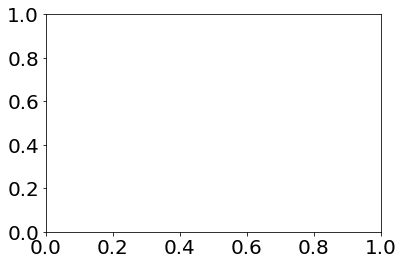

In [55]:


# Plot outputs
plt.scatter(X_test, y_test, color="black")
#plt.plot(, y_pred, color="blue", linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

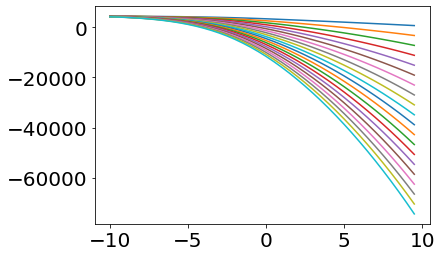

In [27]:
for melt_f in np.arange(10,1000, 50):
    sel = pd_spec_mb.loc[pd_spec_mb.melt_f == melt_f]
    plt.plot(sel['temp_bias'], sel['spec_mb_mean'])

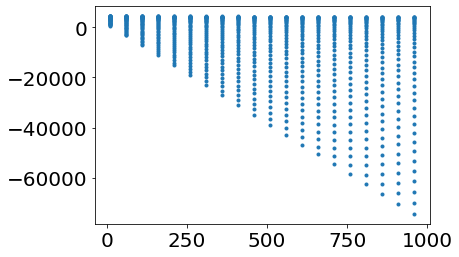

In [25]:
plt.plot(pd_spec_mb['melt_f'], pd_spec_mb['spec_mb_mean'], '.')

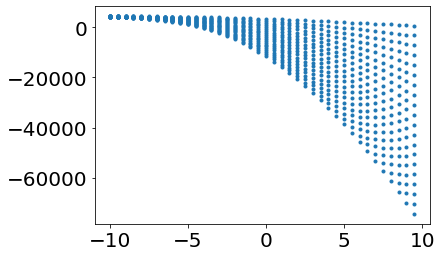

In [24]:
plt.plot(pd_spec_mb['temp_bias'], pd_spec_mb['spec_mb_mean'], '.')

In [7]:
rho_geodetic = 850

# get volume estimates
dV = pd.read_hdf(utils.get_demo_file('rgi62_itmix_df.h5'))

# for potential restricting total ice melt
V_gd_m3 = dV.loc[gd.rgi_id]['vol_itmix_m3']  # m3 volume of HEF
total_mass_gd = V_gd_m3 * rho_geodetic
# this is the area from 2000, could use another estimate (e.g. mean between 2000 and 2020...)
gd_area = pd_geodetic_loc.loc[gd.rgi_id]['area']  # in m2 now !!!
# convert kg --> kg/km2
max_allowed_specificMB = - total_mass_gd / gd_area

h, w = gd.get_inversion_flowline_hw()
if mb_type != 'mb_real_daily':
    cfg.PARAMS['baseline_climate'] = 'ERA5dr'
    oggm.shop.ecmwf.process_ecmwf_data(gd, dataset='ERA5dr')
else:
    cfg.PARAMS['baseline_climate'] = 'ERA5_daily'
    process_era5_daily_data(gd)

ref_df = gd.get_ref_mb_data()

# at instantiation use prcp_fac = 2.5, change this in def_get_mb later on
gd_mb = TIModel(gd, 150, mb_type=mb_type, N=100, prcp_fac=2.5,
                grad_type=grad_type)

NameError: name 'gd' is not defined

In [ ]:
bayes_calib_geod_direct.